In [165]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import itertools
import warnings

warnings.filterwarnings("ignore") # отключает предупреждения

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Загружаем датасет

In [166]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [167]:
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


### Производим ресемплинг

In [168]:
df_w = df.copy().resample('W').mean()
df_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


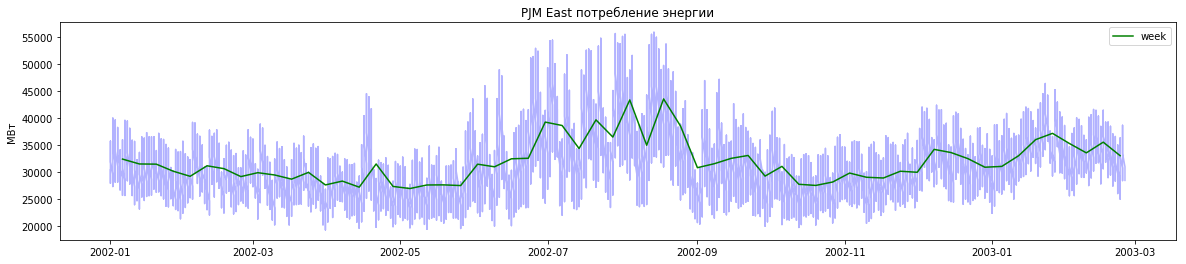

In [169]:
plt.figure(figsize =(20,4))
plt.plot( df.index[:5*24*7*4*3], df['PJME_MW'].values[:5*24*7*4*3], 'b', alpha=0.3)
plt.plot( df_w.index[:5*4*3], df_w['PJME_MW'].values[:5*4*3], 'g',label='week')
plt.title('PJM East потребление энергии' )
plt.ylabel('МВт')
plt.legend()

In [170]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [171]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [172]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Производим подобор параметров

In [173]:
p = range(4, 12, 2)
d = range(0, 3)
q = range(1, 4)

# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# в прошлый раз мы вяснили, что для 26 недель эти параметры являются оптимальными
seasonal_pdq = [1, 1, 2, 26]

In [174]:
'''
best_params = {
    'aic': np.inf
}
for params in pdq:
    print(f'Params: {params}')
    try:
        model = sm.tsa.statespace.SARIMAX(df_w['PJME_MW'].values[:-30], 
                                order=params,
                                seasonal_order=seasonal_pdq,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

        result = model.fit(maxiter=200)
        print(f'ARIMA{params}x{seasonal_pdq}26 - AIC:{result.aic}')

        if result.aic < best_params['aic']:
            print('New best params')
            best_params['aic'] = result.aic
            best_params['params'] = (params, seasonal_pdq)
    except Eception as e:
        print('Error: ', e)
        continue
'''

"\nbest_params = {\n    'aic': np.inf\n}\nfor params in pdq:\n    print(f'Params: {params}')\n    try:\n        model = sm.tsa.statespace.SARIMAX(df_w['PJME_MW'].values[:-30], \n                                order=params,\n                                seasonal_order=seasonal_pdq,\n                                enforce_stationarity=False,\n                                enforce_invertibility=False)\n\n        result = model.fit(maxiter=200)\n        print(f'ARIMA{params}x{seasonal_pdq}26 - AIC:{result.aic}')\n\n        if result.aic < best_params['aic']:\n            print('New best params')\n            best_params['aic'] = result.aic\n            best_params['params'] = (params, seasonal_pdq)\n    except Eception as e:\n        print('Error: ', e)\n        continue\n"

In [175]:
# best_params

ARIMA(4, 0, 2)x[1, 1, 2, 26]26 - AIC:13757.76191538776 - наилучшие найденные параметры

Однако:
ARIMA(10, 1, 1)x[1, 1, 2, 26]26 - AIC:13766.256667556903 - что соответствует заданию (p=10, d=1) тоже весьма неплохой результат. Продолжит, используя эти параметры.

### Добавляем первые разности (т.к. d = 1)

In [176]:
first_diff = df_w.iloc[1:,0].values - df_w.iloc[:-1,0].values 
df_w['diff1'] = 0
df_w['diff1'].values[1:] = first_diff

### Добавляем истории длиной p в признаках автокорреляции

In [177]:
p = 10 # дано в задаче

In [178]:
for i in range(p):
    df_w['t'+str(p-i)]=0
    df_w['t'+str(p-i)].values[p:] = df_w['PJME_MW'].values[i:-(p)+i]

### Добавляем первые разности длиной p

In [179]:
for i in range(p):
    df_w['d'+str(p-i)]=0
    df_w['d'+str(p-i)].values[p:] = df_w['diff1'].values[i:-(p)+i]

### Добавляем скользящую среднюю

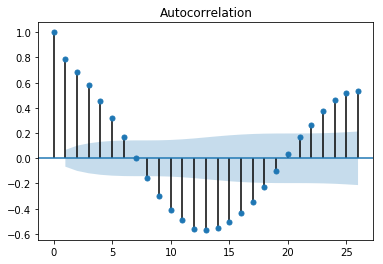

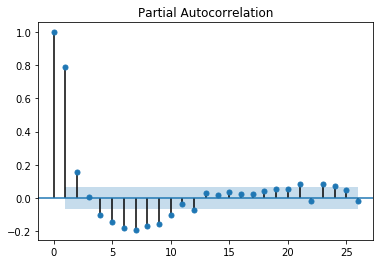

In [180]:
sm.graphics.tsa.plot_acf(df_w['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(df_w['PJME_MW'].values, lags=26)
plt.show()

In [181]:
df_w['d_w13'] = df_w['PJME_MW'].rolling(window=13).mean() # окно 13
df_w = df_w.fillna(0)

### Добавим экспоненциальное среднее

In [182]:
df_w['exp_0_05'] = exponential_smoothing(df_w['PJME_MW'], 0.05)

In [183]:
df_w.head(20)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,...,d8,d7,d6,d5,d4,d3,d2,d1,d_w13,exp_0_05
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.580420,0.160839,...,0,0,0,0,0,0,0,0,0.000000,32392.160839
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.500000,0.000000,...,0,0,0,0,0,0,0,0,0.000000,32346.922142
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.500000,0.000000,...,0,0,0,0,0,0,0,0,0.000000,32302.220083
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.500000,0.142857,...,0,0,0,0,0,0,0,0,0.000000,32194.185567
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.500000,0.000000,...,0,0,0,0,0,0,0,0,0.000000,32044.300693
2002-02-10,31150.517857,2002.0,2.000000,7.000000,1.0,38.000000,6.0,3.000000,11.500000,0.000000,...,0,0,0,0,0,0,0,0,0.000000,31999.611551
2002-02-17,30616.565476,2002.0,2.000000,14.000000,1.0,45.000000,7.0,3.000000,11.500000,0.000000,...,0,0,0,0,0,0,0,0,0.000000,31930.459248
2002-02-24,29144.130952,2002.0,2.000000,21.000000,1.0,52.000000,8.0,3.000000,11.500000,0.142857,...,0,0,0,0,0,0,0,0,0.000000,31791.142833
2002-03-03,29869.011905,2002.0,2.428571,16.000000,1.0,59.000000,9.0,3.000000,11.500000,0.000000,...,0,0,0,0,0,0,0,0,0.000000,31695.036287


## Произведём подбор признаков

Будем расчитывать предсказание на 4 дня вперёд (h=4) как указано в задании

In [184]:
h=4

In [185]:
scaler_t = StandardScaler() 

target = df_w['PJME_MW'].values[h+p:].reshape((df_w.shape[0]-h-p,1))
y = scaler_t.fit_transform(target)
y.shape

(852, 1)

In [186]:
scaler_x = StandardScaler() 

X = df_w.iloc[p:-h,:].values
X = scaler_x.fit_transform(X.astype('float64'))
X.shape

(852, 35)

### Используем различные методы выбора признаков

#### SelectKBest

In [187]:
sfk = SelectKBest(f_regression, k=5)
sfk.fit(X, y.ravel())

SelectKBest(k=5, score_func=<function f_regression at 0x1c303d80d0>)

In [188]:
df_w.columns[sfk.get_support()]

Index(['PJME_MW', 't10', 't9', 't8', 't7'], dtype='object')

#### SelectPercentile

In [189]:
sfp = SelectPercentile(f_regression, percentile=10)
sfp.fit(X, y.ravel())

SelectPercentile(percentile=10,
         score_func=<function f_regression at 0x1c303d80d0>)

In [190]:
df_w.columns[sfp.get_support()]

Index(['t10', 't9', 't8', 't7'], dtype='object')

#### FromModel

In [191]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())

SelectFromModel(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
        max_features=5, norm_order=1, prefit=False, threshold=None)

In [192]:
df_w.columns[sfm.get_support()]

Index(['PJME_MW', 'dayofyear', 't10', 't9', 't8'], dtype='object')

In [193]:
list_param_k = np.where(sfk.get_support())[0]
list_param_p = np.where(sfp.get_support())[0]
list_param_m = np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 13 14 15 16]
Номера признаков лучших признаков по процентной форме:  [13 14 15 16]
Номера признаков для выбора по модели :  [ 0  5 13 14 15]


Соберём все признаки и будем использвоать их для дальнейшего построения модели

In [194]:
list_par=[0, 5, 13, 14, 15, 16]
X_new = X[:, list_par]
df_w.columns[list_par]

Index(['PJME_MW', 'dayofyear', 't10', 't9', 't8', 't7'], dtype='object')

## Готовим модель

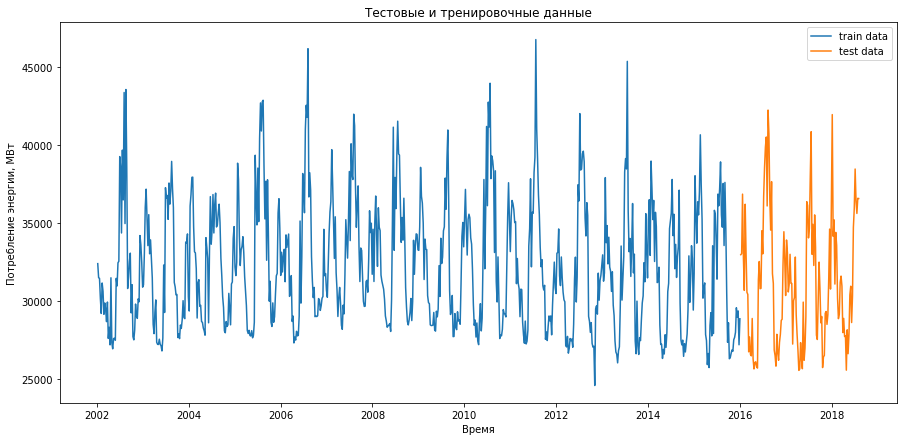

In [195]:
train, test = split_data(df_w, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'), train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'), test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [196]:
X_train_4 = X_new[:train.shape[0],:]
y_train_4 = y[:train.shape[0],0]
X_test_4 = X_new[train.shape[0]:,:]
y_test_4 = y[train.shape[0]:,0]

In [197]:
model_g = GradientBoostingRegressor(max_depth=1, random_state=100, n_estimators=200)

In [198]:
model_g.fit(X_train_4, y_train_4)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=100, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [199]:
y_pred_4 = model_g.predict(X_test_4)

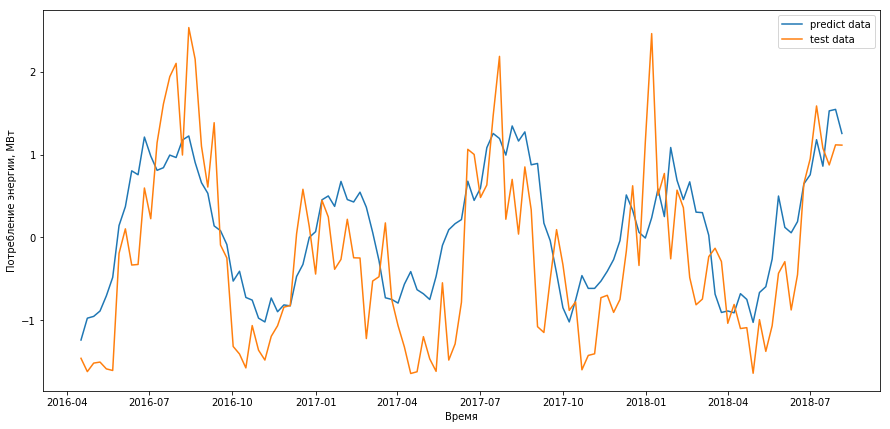

In [200]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:], y_pred_4, label='predict data' )
plt.plot(test.index[h+p:], y_test_4, label='test data')

plt.legend()
plt.show()

In [201]:
er_s = mean_squared_error(y_true=y_test_4, y_pred=y_pred_4) 
er_a = mean_absolute_error(y_true=y_test_4, y_pred=y_pred_4) 
er_r2 = r2_score(y_true=y_test_4, y_pred=y_pred_4)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.5769215121381606 
ошибка mae  :   0.6256346628520196 
оценка R2 :   0.46488735584345153


In [202]:
er_g = mean_absolute_percentage_error(y_true=scaler_t.inverse_transform(y_test_4), y_pred = scaler_t.inverse_transform(y_pred_4))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   8.217976728984198 %


Отлично, это были результаты предсказания на 4 дня вперёд. Ошибка не самая маленькая, но и вполне допустимая (как известно, подобные вещи необходимо обговаривать с заказчиком).

### Теперь построим аналогичную модель для 1 дня (h=1)

In [203]:
h=1

In [204]:
scaler_t = StandardScaler() 

target = df_w['PJME_MW'].values[h+p:].reshape((df_w.shape[0]-h-p,1))
y = scaler_t.fit_transform(target)
y.shape

(855, 1)

In [205]:
scaler_x = StandardScaler() 

X = df_w.iloc[p:-h,:].values
X = scaler_x.fit_transform(X.astype('float64'))
X.shape

(855, 35)

Воспользуемся теми же признаками, что и в прошлый раз

In [206]:
list_par=[0, 5, 13, 14, 15, 16]
X_new = X[:, list_par]
df_w.columns[list_par]

Index(['PJME_MW', 'dayofyear', 't10', 't9', 't8', 't7'], dtype='object')

#### Выбираем train и test

In [207]:
X_train = X_new[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X_new[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

In [208]:
model_g = GradientBoostingRegressor(max_depth=1, random_state=100, n_estimators=200)

In [209]:
model_g.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=100, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [210]:
y_pred = model_g.predict(X_test)

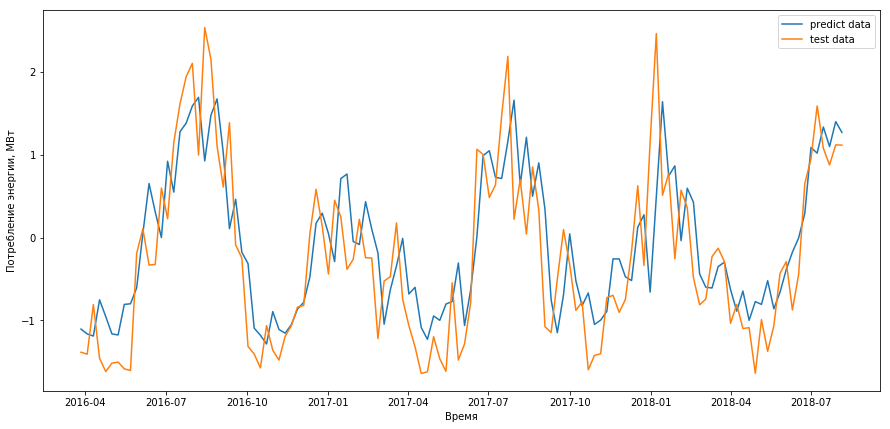

In [211]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:], y_pred, label='predict data' )
plt.plot(test.index[h+p:], y_test, label='test data')

plt.legend()
plt.show()

In [212]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_pred) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_pred) 
er_r2 = r2_score(y_true=y_test, y_pred=y_pred)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.4089606484357092 
ошибка mae  :   0.5143607778753619 
оценка R2 :   0.6203592050887874


In [213]:
er_g = mean_absolute_percentage_error(y_true=scaler_t.inverse_transform(y_test), y_pred = scaler_t.inverse_transform(y_pred))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.611222046386062 %


Как и ожидалось, ошибка уменьшилась, т.к. уменишился горизонт предсказаний. Возможно, настройка гиперпараметров модели и подбор признаков помогут снизить её ещё больше.

## Строим предсказание 4й точки методом рекурсивного моделирования

In [215]:
# ['PJME_MW', 'dayofyear', 't10', 't9', 't8', 't7']

X_test_r = X_test.copy()
y_test_r = y_pred.copy()

Nh = 4 # по сути это наша h=4
for i in range(Nh):
    y_test_r[i] = model_g.predict(X_test_r[i,:].reshape((1,6)))
    X_test_r[i+1, 0] = y_test_r[i]
    # при предсказании большего количества дней, нам пришлось бы дополнять историю, но т.к. у нас используется история начиная с 7, то в этом нет необходимости

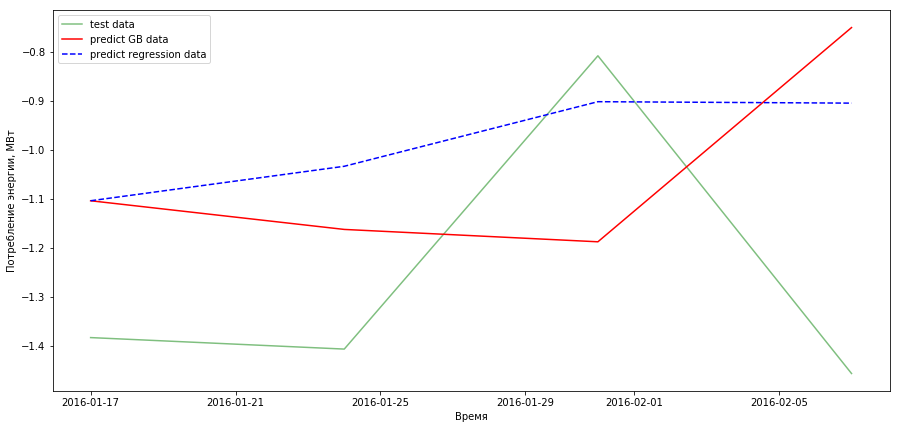

In [216]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:Nh+1], y_test[:Nh], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:Nh+1], y_pred[:Nh], 'r',label='predict GB data' )
plt.plot(test.index[1:Nh+1], y_test_r[:Nh], '--b',label='predict regression data')

plt.legend()
plt.show()

In [217]:
er_g = mean_absolute_percentage_error(y_true=scaler_t.inverse_transform(y_test[:Nh]),y_pred=scaler_t.inverse_transform(y_test_r[:Nh]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.882444711205011 %


Интересно, показатель ошибки получился даже ниже, чем у GB

### Построим модели на большее количество дней

In [229]:
# ['PJME_MW', 'dayofyear', 't10', 't9', 't8', 't7']

for Nh in range(1, 100, 10):
    for i in range(Nh):
        y_test_r[i] = model_g.predict(X_test_r[i,:].reshape((1,6)))
        X_test_r[i+1, 0] = y_test_r[i]

        if i > 5:
            X_test_r[i+1, 5] = X_test_r[i-6, 0]
        if i > 6:
            X_test_r[i+1, 4] = X_test_r[i-7, 0]
        if i > 7:
            X_test_r[i+1, 3] = X_test_r[i-8, 0]
        if i > 8:
            X_test_r[i+1, 2] = X_test_r[i-9, 0]
            
    er_g = mean_absolute_percentage_error(y_true=scaler_t.inverse_transform(y_test[:Nh]),y_pred=scaler_t.inverse_transform(y_test_r[:Nh]))
    print(f'ошибка градиентного бустинга MAPE на {Nh} точек', er_g,'%')

ошибка градиентного бустинга MAPE на 1 точек 4.202272064507222 %
ошибка градиентного бустинга MAPE на 11 точек 11.258200638672971 %
ошибка градиентного бустинга MAPE на 21 точек 10.86836205550731 %
ошибка градиентного бустинга MAPE на 31 точек 10.239050167918979 %
ошибка градиентного бустинга MAPE на 41 точек 9.268905356336298 %
ошибка градиентного бустинга MAPE на 51 точек 8.990689303758739 %
ошибка градиентного бустинга MAPE на 61 точек 8.869611002714677 %
ошибка градиентного бустинга MAPE на 71 точек 8.88120079363663 %
ошибка градиентного бустинга MAPE на 81 точек 8.778729472624233 %
ошибка градиентного бустинга MAPE на 91 точек 8.460655474584494 %


С увеличением длины прогноза ошибка стала снижаться, что очень странно. Чем дальше горизонт прогноза, тем вышу должна быть ошибка.  
Наверное, я что-то напутал с дополнением истории